# DATA VISUALIZATIONS FOR WIKIMEDIA API 

This notebook contains the required data wrangling and visualization code for this project.

The following packages are required to be imported for this notebook: 

In [129]:
import json
import plotly.express as px
import pandas as pd
from PIL import Image
from IPython.display import display

## Analysis 1: Max and Min Average View Desktop & Mobile

## 1.1 Reading In Files and Basic Data Manipulation

First, we read in the two json objects corresponding to desktop and mobile.

In [106]:
# Read in Files 
with open("../../data/rare-disease_monthly_desktop_2015070100-2024093000.json", "r") as file:
    monthly_desktop = json.load(file)
with open("../../data/rare-disease_monthly_mobile_2015070100-2024093000.json", "r") as file:
    monthly_mobile = json.load(file)    

Next, we extract a flat list of dictionaries corresponding to each article. Each list can be turned into a pandas dataframe, where each key corresponds to a different column of the dataframe. We append each article to a list, and concatenate them to produce a cleaned dataframe for each access.

In [107]:
#initialize desktop df list 
monthly_desktop_df_list = []
#loop through articles and create dataframe for each, append to list
for i in monthly_desktop.keys():
    monthly_desktop_df_list.append(pd.DataFrame(monthly_desktop[i]))
#concat dataframes for each article into a large dataframe
monthly_desktop_df = pd.concat(monthly_desktop_df_list)
#repeat for mobile 
monthly_mobile_df_list = []
for i in monthly_mobile.keys():
    monthly_mobile_df_list.append(pd.DataFrame(monthly_mobile[i]))
monthly_mobile_df = pd.concat(monthly_mobile_df_list)

Some additional cleaning that will make time series easier in the future is to convert the timestamp to a datetime column type in pandas. Also we replace hyphens in the article name in desktop with space.

In [108]:
#Timestamp to datetime 
monthly_desktop_df.timestamp = pd.to_datetime(monthly_desktop_df.timestamp,
                                            format='%Y%m%d%H')
#replace hyphens with spaces 
monthly_desktop_df.article = monthly_desktop_df.article.str.replace('_', ' ')
#Timestamp to datetime
monthly_mobile_df.timestamp = pd.to_datetime(monthly_mobile_df.timestamp,
                                            format='%Y%m%d%H')

## 1.2 Performing Required Aggregation

First, we have to group by the article type and aggregate the views to get the mean views per article.

In [109]:
#group by article to get aggregate table of means
monthly_desktop_agg = monthly_desktop_df.groupby('article').agg({'views' : ['mean']})
monthly_mobile_agg = monthly_mobile_df.groupby('article').agg({'views' : ['mean']})

Here we create a dictionary for each access type. The key of the dictionary is the name of either the max average or mean average article. The value is a string containing a description of the whether the article is the max or min and the access type, followed by the article name. 

In [110]:
#Store max and min article names and description in a dictionary per access type
desktop_stats = {
    monthly_desktop_agg[monthly_desktop_agg['views', 'mean'] == monthly_desktop_agg['views', 'mean'].max()].index[0] : 
    f"Max Average Desktop : {monthly_desktop_agg[monthly_desktop_agg['views', 'mean'] == monthly_desktop_agg['views', 'mean'].max()].index[0]}" ,
    monthly_desktop_agg[monthly_desktop_agg['views', 'mean'] == monthly_desktop_agg['views', 'mean'].min()].index[0] : 
    f"Min Average Desktop : {monthly_desktop_agg[monthly_desktop_agg['views', 'mean'] == monthly_desktop_agg['views', 'mean'].min()].index[0]}"
}  
mobile_stats = {
    monthly_mobile_agg[monthly_mobile_agg['views', 'mean'] == monthly_mobile_agg['views', 'mean'].max()].index[0] : 
    f"Max Average Mobile : {monthly_mobile_agg[monthly_mobile_agg['views', 'mean'] == monthly_mobile_agg['views', 'mean'].max()].index[0]}",
    monthly_mobile_agg[monthly_mobile_agg['views', 'mean'] == monthly_mobile_agg['views', 'mean'].min()].index[0] : 
    f"Min Average Mobile : {monthly_mobile_agg[monthly_mobile_agg['views', 'mean'] == monthly_mobile_agg['views', 'mean'].min()].index[0]}" 
}  

We filter the larger data frame for each access type to the max and min mean article names we found earlier. Additionally, we create
a 'Category' column which we can use to identify a description of the article via the pandas map function. This function maps the values of a column to keys of a dictionary, and creates a different column based on the value corresponding to mapped keys. Also we concatenate the the filtered dataframes into one dataframe for plotting.

In [111]:
#Per access type, filter large df to max and min and create category column. 
min_max_monthly_desktop = monthly_desktop_df[monthly_desktop_df['article'].isin(desktop_stats.keys())]
min_max_monthly_desktop['Category'] = min_max_monthly_desktop['article'].map(desktop_stats)
min_max_monthly_mobile = monthly_mobile_df[monthly_mobile_df['article'].isin(mobile_stats.keys())]
min_max_monthly_mobile['Category'] = min_max_monthly_mobile['article'].map(mobile_stats)
min_max_monthly = pd.concat([min_max_monthly_desktop, min_max_monthly_mobile])

print(desktop_stats)
print(mobile_stats)

{'Black Death': 'Max Average Desktop : Black Death', 'Filippi Syndrome': 'Min Average Desktop : Filippi Syndrome'}
{'Black Death': 'Max Average Mobile : Black Death', 'Filippi Syndrome': 'Min Average Mobile : Filippi Syndrome'}


/var/folders/_p/bxhqsmnd5w54bhnc_zblrb9h0000gq/T/ipykernel_12505/2211440687.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_p/bxhqsmnd5w54bhnc_zblrb9h0000gq/T/ipykernel_12505/2211440687.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 1.3 Plot and Save Image 

Here we use the plotly express package to generate a line plot. We make a slight adjustment to the line trace for the min average mobile, since it overlaps with the min average desktop line. We then save the figure into the image directory. We also display the view count on a log scale since we want to visualize trends but view count varies significantly between articles.

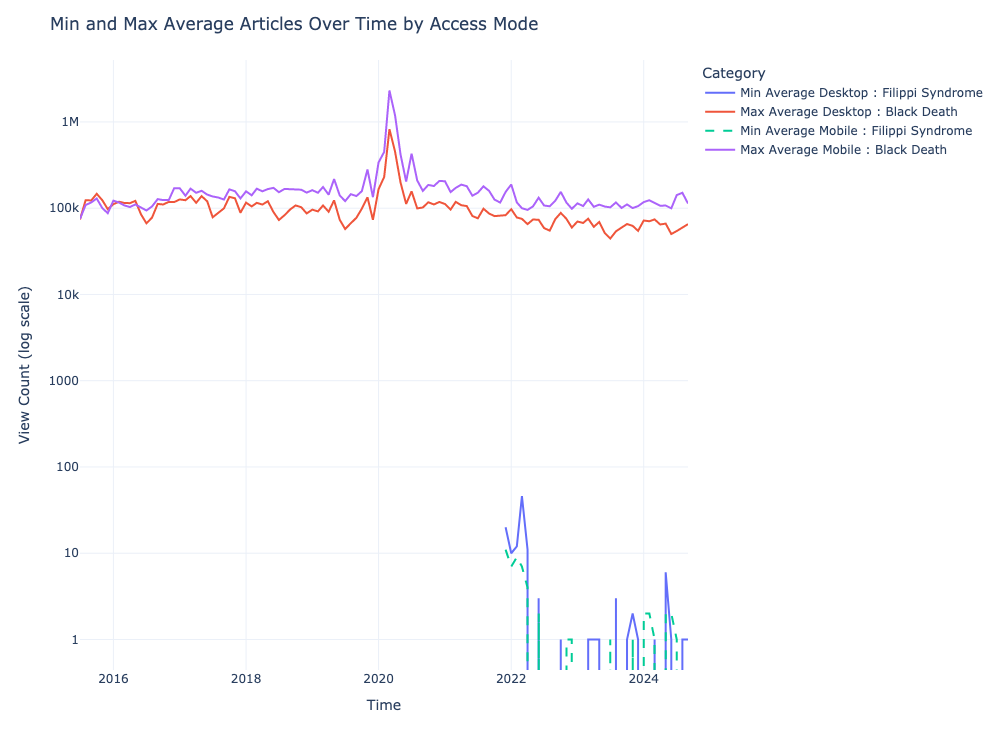

In [130]:
# set up fig with px.line, where color is the description we have generated
fig = px.line(min_max_monthly,
        x = 'timestamp',
        y = 'views',
        color = "Category",
        template = 'plotly_white',
        log_y = True
        )
#update the size and titles
fig.update_layout(
    title="Min and Max Average Articles Over Time by Access Mode",
    xaxis_title='Time',
    yaxis_title='View Count (log scale)',
    height = 750,
    width = 1000
)
#adjust trace so we can see min for both desktop and mobile
for trace in fig.data:
    if trace.name == 'Min Average Mobile : Filippi Syndrome':
        trace.line.dash = 'dash'  
#show figure in notebook and write image
fig.write_image("../../imgs/max_average_min_average_plot.png")

with Image.open("../../imgs/max_average_min_average_plot.png") as img:
    display(img)

# Analysis 2: Top 10 Peak Page Views Desktop & Mobile

## 2.1 Data Wrangling and Aggregation

Set up dictionaries to track top 10 articles by peak view across the time series. Key will be the name of the article, and the value will be a brief description of the article access source and article title. 

In [114]:
#init dictionary, and find top 10 articles by peak views 
top10_monthly_desktop_dict = {}
top10_desktop_article_list = monthly_desktop_df.groupby('article').agg({'views' : max}).sort_values(by = 'views', ascending=False)[0:10].index.tolist()
#fill dictionary with "Category" field to be populated downstream
for article in top10_desktop_article_list:
    top10_monthly_desktop_dict[article] = f"Top Peak View Desktop : {article}"
#repeat for mobile
top10_monthly_mobile_dict = {}
top10_mobile_article_list = monthly_mobile_df.groupby('article').agg({'views' : max}).sort_values(by = 'views', ascending=False)[0:10].index.tolist()
for article in top10_mobile_article_list:
    top10_monthly_mobile_dict[article] = f"Top Peak View Mobile : {article}"

print(f"Top 10 Peak Desktop Articles are: {top10_desktop_article_list}")
print(f"Top 10 Peak Mobile Articles are: {top10_mobile_article_list}")

Top 10 Peak Desktop Articles are: ['Pandemic', 'Black Death', 'Chloroquine', 'Pfeiffer syndrome', 'Fibrodysplasia ossificans progressiva', 'Botulism', 'Robert Koch', 'Smallpox', 'Cleidocranial dysostosis', 'Amyotrophic lateral sclerosis']
Top 10 Peak Mobile Articles are: ['Black Death', 'Pandemic', 'Pfeiffer syndrome', 'Chloroquine', 'Stiff-person syndrome', 'Porphyria', 'Glioblastoma', 'Cleidocranial dysostosis', 'Botulism', 'Kawasaki disease']


/var/folders/_p/bxhqsmnd5w54bhnc_zblrb9h0000gq/T/ipykernel_12505/1917323865.py:3: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.

/var/folders/_p/bxhqsmnd5w54bhnc_zblrb9h0000gq/T/ipykernel_12505/1917323865.py:9: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.



We filter the larger data frames for the peak articles. Additionally, we create a 'Category' column which we can use to identify a description of the article via the pandas map function. This function maps the values of a column to keys of a dictionary, and creates a different column based on the value corresponding to mapped keys. Also we concatenate the the filtered dataframes into one dataframe for plotting.

In [115]:
#filter to the top 10 articles for both desktop and mobile 
top10_desktop_article_df = monthly_desktop_df[monthly_desktop_df.article.isin(top10_desktop_article_list)]
top10_mobile_article_df = monthly_mobile_df[monthly_mobile_df.article.isin(top10_mobile_article_list)]
#Make category using map function in pandas
top10_desktop_article_df['Category'] = top10_desktop_article_df.article.map(top10_monthly_desktop_dict)
top10_mobile_article_df['Category'] = top10_mobile_article_df.article.map(top10_monthly_mobile_dict)
#concat desktop and article 
top10_peak_articles_df = pd.concat([top10_desktop_article_df, top10_mobile_article_df])

/var/folders/_p/bxhqsmnd5w54bhnc_zblrb9h0000gq/T/ipykernel_12505/594512277.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_p/bxhqsmnd5w54bhnc_zblrb9h0000gq/T/ipykernel_12505/594512277.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 2.2 Plot and Save Images

Here we use the plotly express package to generate a line plot. We also display the view count on a log scale since we want to visualize trends but view count varies significantly between articles. We then save the figure into the image directory.

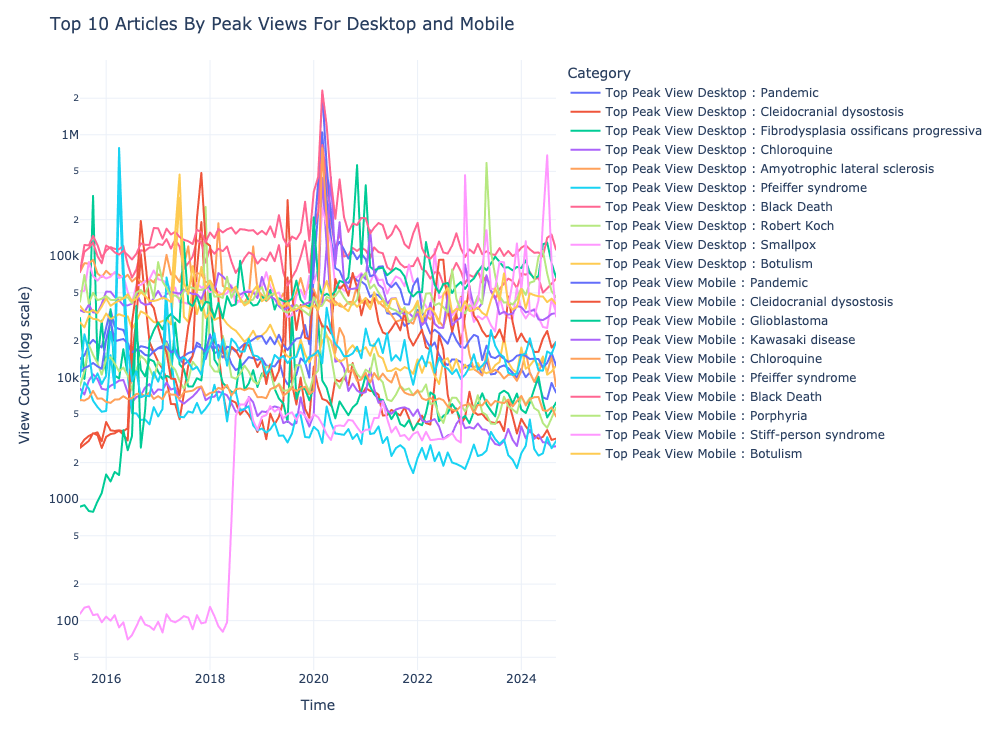

In [131]:
#Set up fig with px line
fig = px.line(top10_peak_articles_df,
        x = 'timestamp',
        y = 'views',
        color = "Category",
        template = 'plotly_white',
        log_y = True
        )
#update size and titles
fig.update_layout(
    title = "Top 10 Articles By Peak Views For Desktop and Mobile",
    xaxis_title='Time',
    yaxis_title='View Count (log scale)',
    height = 750,
    width = 1000
)
#show fig and save images 
fig.write_image("../../imgs/top10_peak_articles_mobile_desktop_plot.png")

with Image.open("../../imgs/top10_peak_articles_mobile_desktop_plot.png") as img:
    display(img)

# Analysis 3: Fewest 10 Months of Data Desktop & Mobile

## 3.1 Data Wrangling and Aggregation 

Here we filter down to the 10 articles with the fewest months of data using pandas and the timestamp field. 

In [119]:
#find fewest 10 articles with data per access
fewest_10_desktop_list = monthly_desktop_df.groupby('article').agg({'timestamp' : 'nunique'}).sort_values(by = 'timestamp')[0:10].index.tolist()
fewest_10_mobile_list = monthly_mobile_df.groupby('article').agg({'timestamp' : 'nunique'}).sort_values(by = 'timestamp')[0:10].index.tolist()

We next filter down the original dataframes to these articles.

In [120]:
#filter to the fewest 10 articles for both desktop and mobile 
fewest10_desktop_article_df = monthly_desktop_df[monthly_desktop_df.article.isin(fewest_10_desktop_list)]
fewest10_mobile_article_df = monthly_mobile_df[monthly_mobile_df.article.isin(fewest_10_mobile_list)]

Set up dictionaries to track 10 articles with the fewest number of recorded months across the time series. Key will be the name of the article, and the value will be a brief description of the article access source and article title. Additionally, we create a 'Category' column which we can use to identify a description of the article via the pandas map function. This function maps the values of a column to keys of a dictionary, and creates a different column based on the value corresponding to mapped keys. Also we concatenate the the filtered dataframes into one dataframe for plotting.

In [121]:
#init dictionary
fewest10_desktop_dict = {}
#fill dictionary with "Category" field to be populated downstream
for article in fewest_10_desktop_list:
    fewest10_desktop_dict[article] = f"10 Fewest Months Desktop : {article}"
#repeat for mobile
fewest10_mobile_dict = {}
for article in fewest_10_mobile_list:
    fewest10_mobile_dict[article] = f"10 Fewest Months Mobile : {article}"

#Create Category column using map and previous dictionary
fewest10_desktop_article_df['Category'] = fewest10_desktop_article_df.article.map(fewest10_desktop_dict)
fewest10_mobile_article_df['Category'] = fewest10_mobile_article_df.article.map(fewest10_mobile_dict)

#concat into plotting df
fewest10_article_df = pd.concat([fewest10_desktop_article_df, fewest10_mobile_article_df])

/var/folders/_p/bxhqsmnd5w54bhnc_zblrb9h0000gq/T/ipykernel_12505/224686453.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_p/bxhqsmnd5w54bhnc_zblrb9h0000gq/T/ipykernel_12505/224686453.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 3.2 Plot and Save Image

Here we use the plotly express package to generate a line plot. We then save the figure into the image directory. We add a color_discrete_sequence to change the color palette to accommodate many different categories. We also display the view count on a log scale since we want to visualize trends but view count varies significantly between articles.

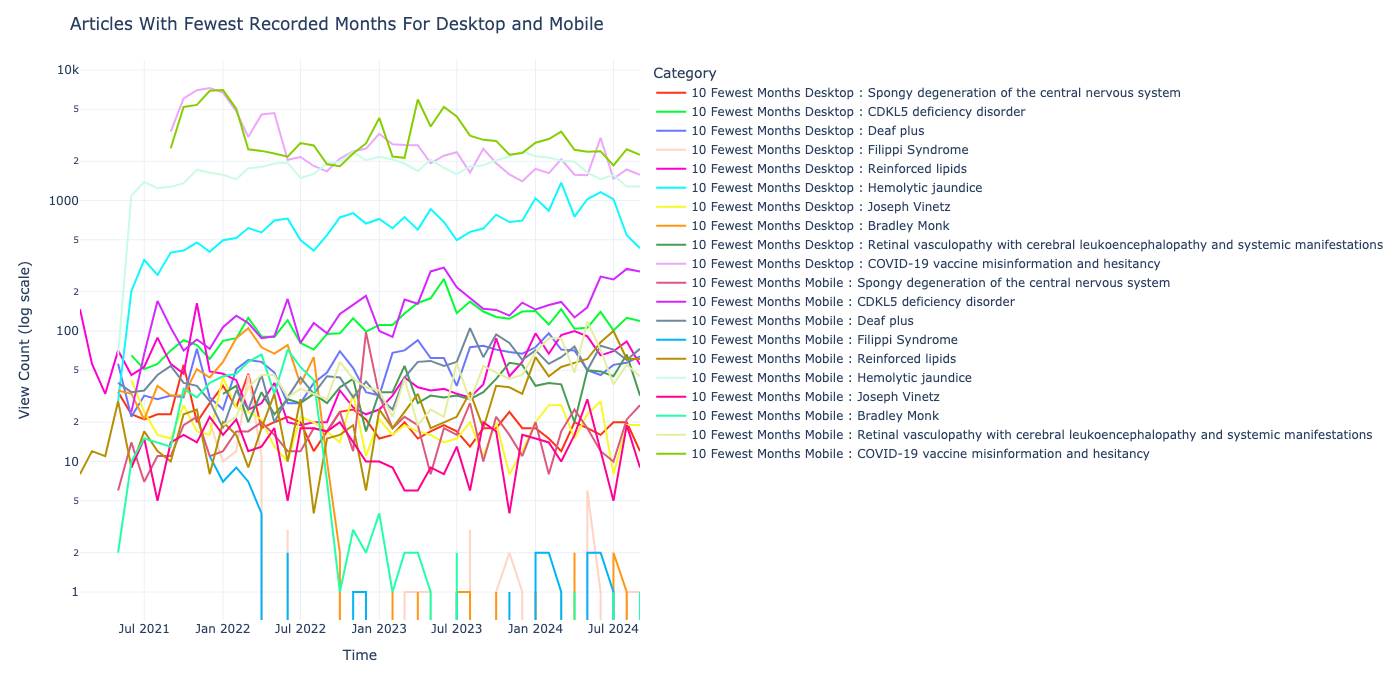

In [132]:
#Set up fig with px line
fig = px.line(fewest10_article_df,
        x = 'timestamp',
        y = 'views',
        color = "Category",
        color_discrete_sequence=px.colors.qualitative.Light24,
        template = 'plotly_white',
        log_y = True)
#update size and titles
fig.update_layout(
    title = "Articles With Fewest Recorded Months For Desktop and Mobile",
    xaxis_title='Time',
    yaxis_title='View Count (log scale)',
    height = 700,
    width = 1400
)
#show fig and save images 
fig.write_image("../../imgs/fewest10_months_articles_mobile_desktop_plot.png")

with Image.open("../../imgs/fewest10_months_articles_mobile_desktop_plot.png") as img:
    display(img)